# How to use Neo4J with LinkML-Store

We will try and use some of the same examples as in [neo4j graph concepts guide](https://neo4j.com/docs/getting-started/appendix/graphdb-concepts/)

![img](https://neo4j.com/docs/getting-started/_images/graph_simple-arr.svg)

__IMPORTANT NOTE__ if you run this Notebook locally, and you have a Neo4J server running,
it will overwrite the default `neo4j` 

In [1]:
from linkml_store import Client

client = Client()

Ensure the database is empty, then connect

In [2]:
db = client.attach_database("neo4j", "test")
db.drop()
db = client.attach_database("neo4j", "test")

## Using a schema

It is not necessary to defined a LinkML schema in advance, but this has a lot of advantages:

- validation
- clarity for producers and consumers
- declarative mappings and graph projections

We'll use a predefined one here. You can see the source schemasheet [here](https://docs.google.com/spreadsheets/d/1oMrzA41tg_nisdWInnqKJrcvv30dOXuwAhznJYYPSB8/edit?gid=1499822522#gid=1499822522)

In [3]:
db.load_schema_view("input/movies_kg/schema.yaml")

Next we'll visualization this using PlamtUML

In [4]:
%%bash
gen-plantuml --directory input/movies_kg/diagrams input/movies_kg/schema.yaml

![img](input/movies_kg/diagrams/MoviesKG.svg)

Note that this is in many respects a "normal" UML type schema, with classes and class relationships.

Here we define to base classes `Node` and `Edge`. We are treating edges as first-class entities in the model.
We are following conventions and using `subject` and `object` for the head and tail nodes.

You don't *need* to define your schema this way. In fact it's possible to map **any** LinkML schema to a property graph. You don't need
classes like "Node" and "Edge", and you don't need a reification type model.
    
But having this kind of "explicit" model is easiest to make the relationship to Neo4J easier to grok.

## Create Node and Edge collections

We create two collections, one for nodes, and one for edges.

Note: you can organize collections how you like - you could have multiple node collections,
(e.g. different collections for persons, movies), and multiple edge collections. However, you can't mix
nodes and edges in one collection. 

In [5]:
node_collection = db.create_collection("Node", alias="nodes", recreate_if_exists=True)
edge_collection = db.create_collection("Edge", alias="nodes", recreate_if_exists=True)

It's necessary to provide some kind of mechanism to indicate which collections are edge collections.
This can be inferred from the schema, but here will will make it explicit.

We'll use a default edge projections, which assigns special meaning to `subject`, `predicate`, and `object`.

In [6]:
from linkml_store.graphs.graph_map import EdgeProjection

edge_collection.metadata.graph_projection = EdgeProjection()

## Adding Data

In [7]:
# For convenience, we assign constants for each of the identifiers in the database
TH = "ACTOR:TH"
RZ = "ACTOR:RZ"
FG = "MOVIE:FG"
BTTF = "MOVIE:BTTF"
FGC = "CHARACTER:FGC"

In [8]:
persons = [
    { "id": TH, "category": "Actor", "name": "Tom Hanks"},
    { "id": RZ, "category": "Director", "name": "Robert Zemekis"},
]
movies = [
    { "id": FG, "category": "Movie", "name": "Forest Gump"},
]
characters = [
    { "id": FGC,"category": "Character", "name": "Forest Gump (Character)"},
]


In [9]:
edges = [
    {"subject": RZ, "predicate": "Directed", "object": FG},
    {"subject": TH, "predicate": "ActedIn", "object": FG, "plays": FGC},
]

In [10]:
node_collection.insert(persons)
node_collection.insert(movies)
node_collection.insert(characters)
edge_collection.insert(edges)

## Visualization

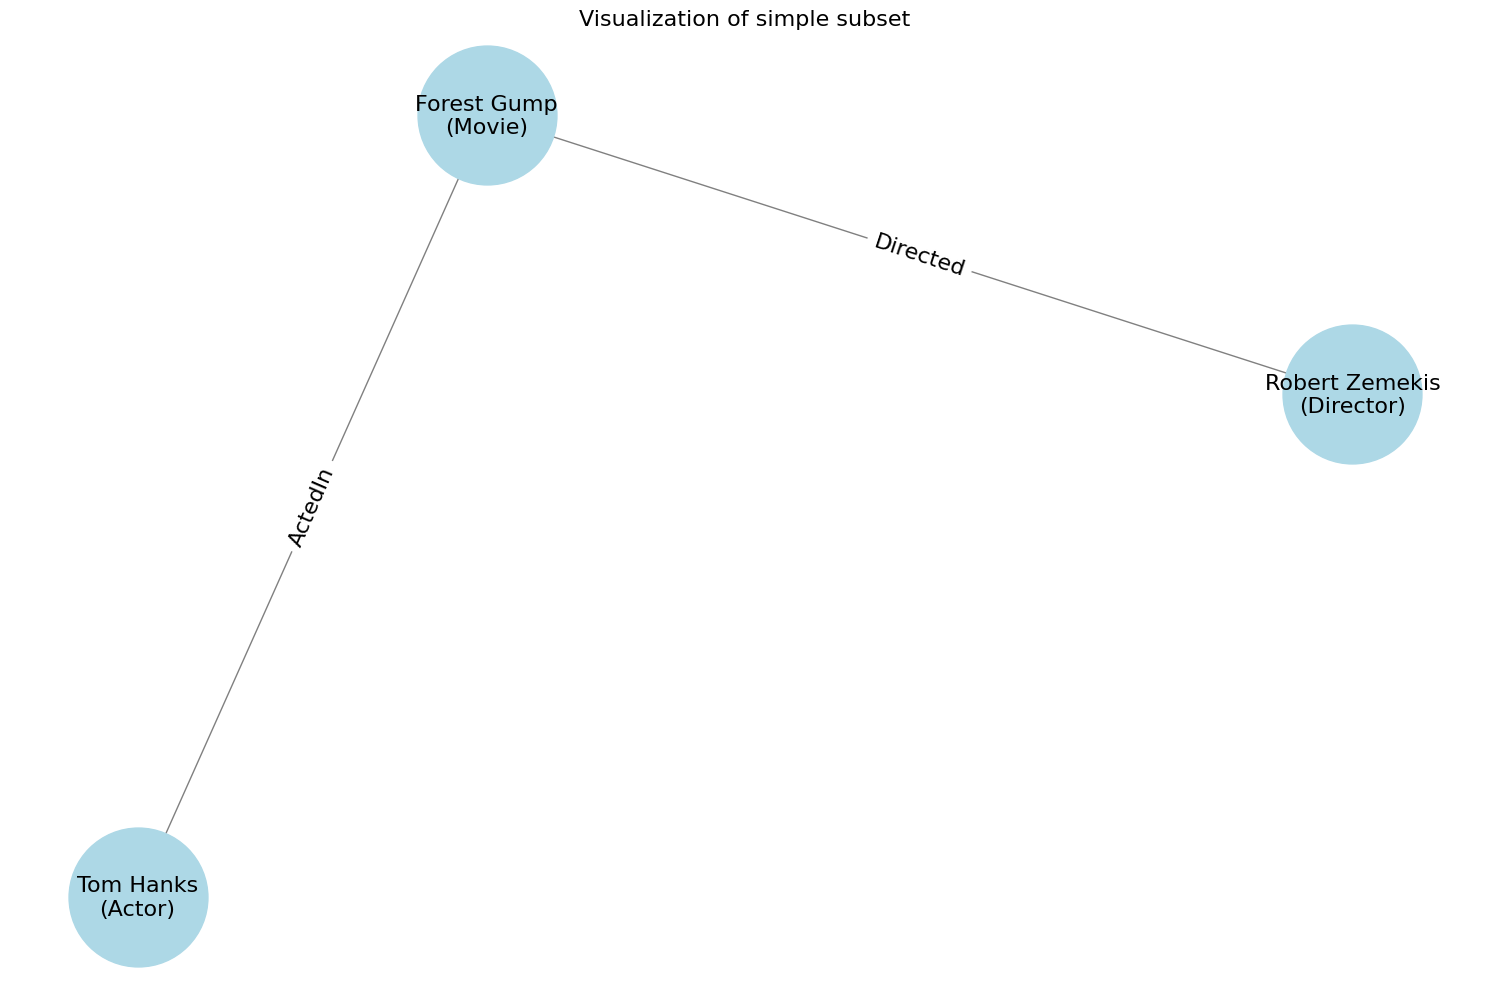

In [11]:
import matplotlib.pyplot as plt
from linkml_store.utils.neo4j_utils import draw_neo4j_graph

plt.figure(figsize=(15, 10))
draw_neo4j_graph()
plt.title("Visualization of simple subset", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

## Validation

In [12]:
edge_collection.metadata.validate_modifications = True


In [13]:
edge_collection.class_definition().attributes.keys()

dict_keys(['subject', 'predicate', 'object'])

In [14]:
try:
    edge_collection.insert({ "subject": RZ, "predicate": "Directed", "object": BTTF, "date": 1985})
except Exception as e:
    print("Got an exception (we expect this!!!)")
    print(e)

Got an exception (we expect this!!!)
Validation errors: [ValidationResult(type='jsonschema validation', severity=<Severity.ERROR: 'ERROR'>, message="Additional properties are not allowed ('date' was unexpected) in /", instance={'subject': 'ACTOR:RZ', 'predicate': 'Directed', 'object': 'MOVIE:BTTF', 'date': 1985}, instance_index=0, instantiates='Directed', context=[])]


## Loading Data from a file

Loading data into a graph is very much like loading any other data into a LinkML schema. So long as you conform
to the schema we defined above (which has defined graph projections), then it can be loaded into Neo4J.

Data could be combined in a single JSON file, but it's also convenient to use tabular or dataframe-oriented formats.

Here we will load from CSV

In [15]:
import pandas as pd


In [16]:
nodes_df = pd.read_csv("input/movies_kg/nodes.csv").convert_dtypes()
nodes_df

,id,category,name,born,released
0,PERSON:TH,Actor,Tom Hanks,1956,<NA>
1,PERSON:RZ,Director,Robert Zemeckis,1951,<NA>
2,PERSON:HW,Actor,Hugo Weaving,1960,<NA>
3,PERSON:KR,Actor,Keanu Reeves,1964,<NA>
4,PERSON:MJF,Actor,Michael J. Fox,1961,<NA>
5,MOVIE:FG,Movie,Forrest Gump,<NA>,1994
6,MOVIE:TM,Movie,The Matrix,<NA>,1999
7,MOVIE:TM2,Movie,The Matrix Reloaded,<NA>,2003
8,MOVIE:TM3,Movie,The Matrix Revolutions,<NA>,2003
9,MOVIE:BTTF,Movie,Back to the Future,<NA>,1985


In [17]:
edges_df = pd.read_csv("input/movies_kg/edges.csv").convert_dtypes()
edges_df

,subject,predicate,object,plays
0,PERSON:TH,ActedIn,MOVIE:FG,CHARACTER:Forrest
1,PERSON:RZ,Directed,MOVIE:FG,<NA>
2,PERSON:RZ,Directed,MOVIE:BTTF,<NA>
3,PERSON:KR,ActedIn,MOVIE:TM,CHARACTER:Neo
4,PERSON:MJF,ActedIn,MOVIE:BTTF,CHARACTER:MartyMcFly
5,PERSON:HW,ActedIn,MOVIE:TM,CHARACTER:AgentSmith


In [18]:
node_collection.insert(nodes_df.to_dict(orient="records"))

In [19]:
# TODO: use type designator in validation 
edge_collection.metadata.validate_modifications = True

In [20]:
edge_collection.insert(edges_df.to_dict(orient="records"))

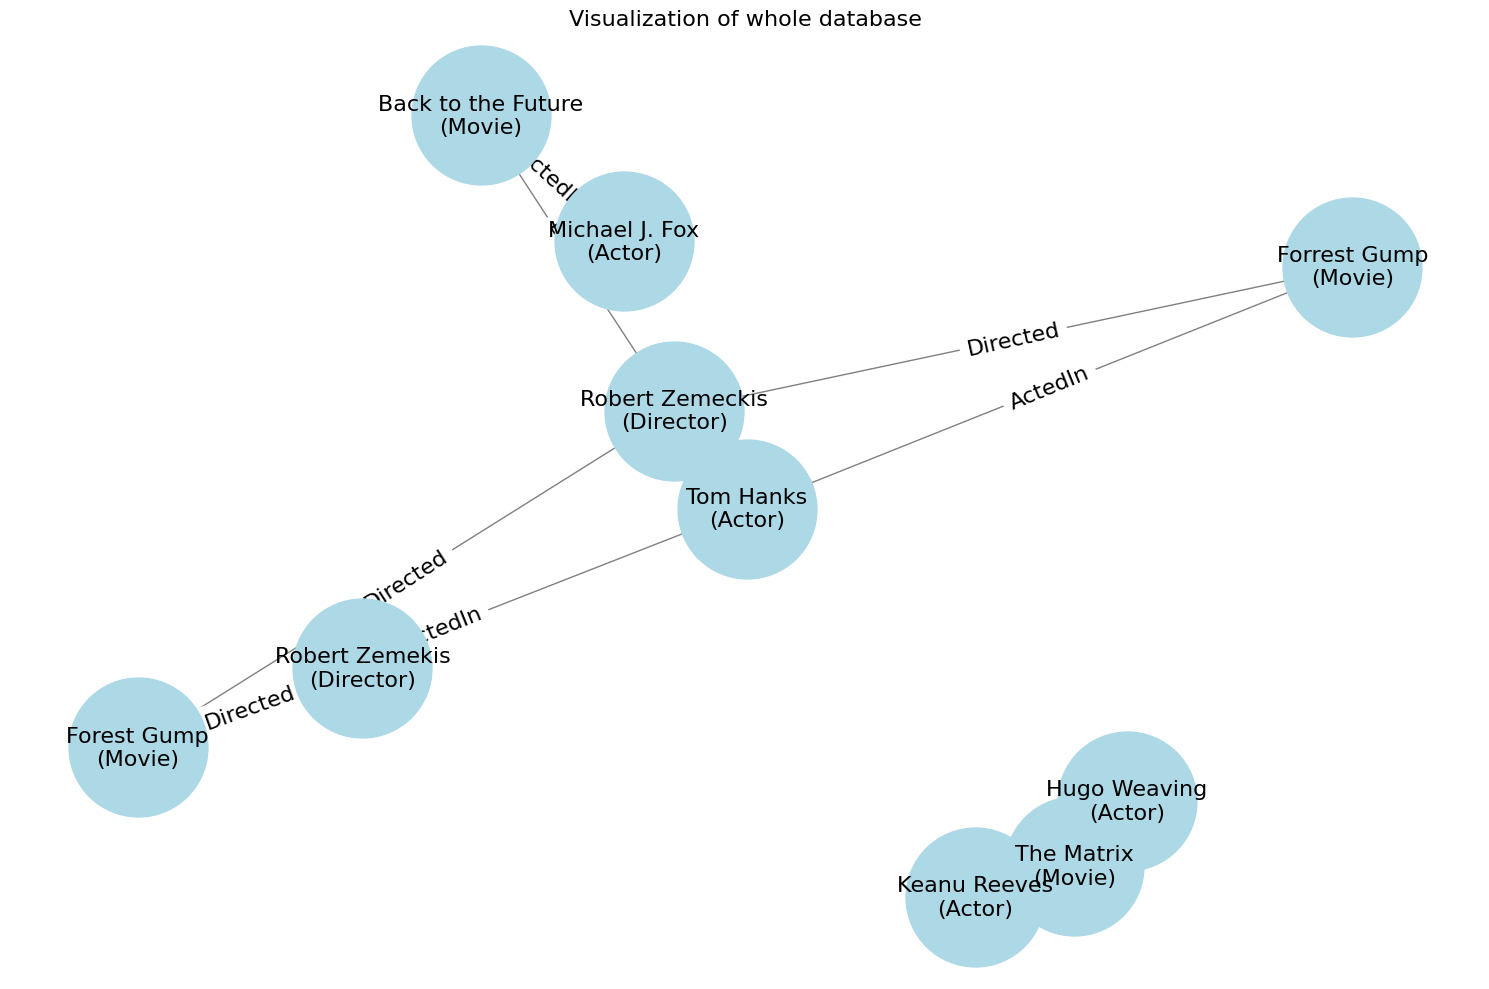

In [21]:
plt.figure(figsize=(15, 10))
draw_neo4j_graph()
plt.title("Visualization of whole database", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

## Queries

In [22]:
node_collection.find().rows_dataframe

,born,name,id,category,released
0,1964.0,Keanu Reeves,PERSON:KR,Actor,NaN
1,1961.0,Michael J. Fox,PERSON:MJF,Actor,NaN
2,NaN,Forrest Gump,MOVIE:FG,Movie,1994.0
3,NaN,The Matrix,MOVIE:TM,Movie,1999.0
4,NaN,The Matrix Reloaded,MOVIE:TM2,Movie,2003.0
5,NaN,The Matrix Revolutions,MOVIE:TM3,Movie,2003.0
6,NaN,Robert Zemekis,ACTOR:RZ,Director,NaN
7,NaN,Back to the Future,MOVIE:BTTF,Movie,1985.0
8,NaN,Forest Gump,MOVIE:FG,Movie,NaN
9,NaN,Forest Gump (Character),CHARACTER:FGC,Character,NaN


In [23]:
edge_collection.find().rows_dataframe

,subject,predicate,object,plays
0,ACTOR:RZ,Directed,MOVIE:FG,NaN
1,ACTOR:TH,ActedIn,MOVIE:FG,CHARACTER:FGC
2,PERSON:TH,ActedIn,MOVIE:FG,CHARACTER:Forrest
3,PERSON:TH,ActedIn,MOVIE:FG,CHARACTER:Forrest
4,PERSON:RZ,Directed,MOVIE:FG,NaN
5,PERSON:RZ,Directed,MOVIE:FG,NaN
6,PERSON:RZ,Directed,MOVIE:BTTF,NaN
7,PERSON:KR,ActedIn,MOVIE:TM,CHARACTER:Neo
8,PERSON:MJF,ActedIn,MOVIE:BTTF,CHARACTER:MartyMcFly
9,PERSON:HW,ActedIn,MOVIE:TM,CHARACTER:AgentSmith


In [25]:
node_collection.find({"category": "Actor"}).rows_dataframe

,born,name,id,category
0,1964.0,Keanu Reeves,PERSON:KR,Actor
1,1961.0,Michael J. Fox,PERSON:MJF,Actor
2,1956.0,Tom Hanks,PERSON:TH,Actor
3,NaN,Tom Hanks,ACTOR:TH,Actor
4,1960.0,Hugo Weaving,PERSON:HW,Actor


In [26]:
edge_collection.find({"predicate": "ActedIn"}).rows_dataframe

,subject,predicate,object,plays
0,ACTOR:TH,ActedIn,MOVIE:FG,CHARACTER:FGC
1,PERSON:TH,ActedIn,MOVIE:FG,CHARACTER:Forrest
2,PERSON:TH,ActedIn,MOVIE:FG,CHARACTER:Forrest
3,PERSON:KR,ActedIn,MOVIE:TM,CHARACTER:Neo
4,PERSON:MJF,ActedIn,MOVIE:BTTF,CHARACTER:MartyMcFly
5,PERSON:HW,ActedIn,MOVIE:TM,CHARACTER:AgentSmith


Note that the main linkml-store API is intended to be generic and does not directly support graph queries.
In future graph API facades will be provided.

## Facet Counts

In [29]:
from linkml_store.utils.pandas_utils import facet_summary_to_dataframe_unmelted

In [30]:
r = node_collection.query_facets(facet_columns=["category"])
facet_summary_to_dataframe_unmelted(r)

,category,Value
0,Movie,6
1,Actor,5
2,Director,2
3,Character,1


In [32]:
# TODO
#r = edge_collection.query_facets(facet_columns=["subject", "predicate", "object"])
#facet_summary_to_dataframe_unmelted(r)

## TODO - mapping non-Graph schemas

TODO - add examples on mapping schemas that are not "natively" PGs